## Setup

In [15]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import os
import urllib.request as urlreq

import torch
import os
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import datasets, transforms, models

## Loading Dataset

In [16]:
train_transforms = transforms.Compose([transforms.ToTensor(),])
test_transforms = transforms.Compose([transforms.ToTensor(),])
val_transforms = transforms.Compose([transforms.ToTensor(),])

train_data = datasets.ImageFolder('images/train', transform=train_transforms)
test_data = datasets.ImageFolder('images/test', transform=test_transforms)
val_data = datasets.ImageFolder('images/validation',transform=val_transforms)

batch = 256

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=True)
valloader =  torch.utils.data.DataLoader(val_data,batch_size=batch, shuffle=True)

In [17]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'


Using the CPU. Overall speed may be slowed down


In [21]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Defining layers
        self.convLayer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2),
            nn.ReLU()
        )
            
        self.convLayer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2),
            nn.ReLU()
        )
        
        self.fcLayer3 = nn.Linear(36864,7) 
        
  
    def forward(self, x):

        #My forward pass 
        x = x.to(device)
        
        #2 layers which do convolution, relu and dropout
        x = self.convLayer1(x)
        x = self.convLayer2(x)
        
        #linear layer so we have right amount of output classes
        x = x.view(x.shape[0],-1)
        x = self.fcLayer3(x)
        
        return x 

model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
print('Your network:')
print(summary(model, (3,48,48), device=device)) # visualize your model


# Set up optimization hyperparameters
learning_rate = 5e-4
weight_decay = 1e-5
num_epoch = 30  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay) # Try different optimizers


Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
           Dropout-2           [-1, 16, 48, 48]               0
              ReLU-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 16, 48, 48]           2,320
           Dropout-5           [-1, 16, 48, 48]               0
              ReLU-6           [-1, 16, 48, 48]               0
            Linear-7                    [-1, 7]         258,055
Total params: 260,823
Trainable params: 260,823
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.69
Params size (MB): 0.99
Estimated Total Size (MB): 2.71
----------------------------------------------------------------
None


In [5]:
%%time
def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        for batch, label in tqdm(trainloader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, trainloader,
                                                  valloader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:13<00:00,  4.32it/s]



 Epoch 1 loss:1.7959119604344953


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.77it/s]



 Evaluation accuracy: 0.29637334442826435

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.55it/s]



 Evaluation accuracy: 0.3038494197565808
-----------------Epoch = 2-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.46it/s]



 Epoch 2 loss:1.6920780466313947


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.99it/s]



 Evaluation accuracy: 0.3673115595312392

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.95it/s]



 Evaluation accuracy: 0.3634305123124823
-----------------Epoch = 3-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.51it/s]



 Epoch 3 loss:1.6121051123267727


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.75it/s]



 Evaluation accuracy: 0.39581166354621733

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.49it/s]



 Evaluation accuracy: 0.3726294933484291
-----------------Epoch = 4-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.12it/s]



 Epoch 4 loss:1.542528882361295


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.82it/s]



 Evaluation accuracy: 0.4363775050273906

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.47it/s]



 Evaluation accuracy: 0.3829606566657232
-----------------Epoch = 5-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.93it/s]



 Epoch 5 loss:1.489641743793822


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.44it/s]



 Evaluation accuracy: 0.47271340406351847

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.76it/s]



 Evaluation accuracy: 0.4091423719218794
-----------------Epoch = 6-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.06it/s]



 Epoch 6 loss:1.4203078663140012


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.22it/s]



 Evaluation accuracy: 0.5012135080784966

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.54it/s]



 Evaluation accuracy: 0.4173506934616473
-----------------Epoch = 7-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.84it/s]



 Epoch 7 loss:1.3606723212359244


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.46it/s]



 Evaluation accuracy: 0.5326260314818667

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  6.99it/s]



 Evaluation accuracy: 0.43136144919332015
-----------------Epoch = 8-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.62it/s]



 Epoch 8 loss:1.295720803110223


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.48it/s]



 Evaluation accuracy: 0.551487414187643

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.60it/s]



 Evaluation accuracy: 0.4262666289272573
-----------------Epoch = 9-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.28it/s]



 Epoch 9 loss:1.237888490944578


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.89it/s]



 Evaluation accuracy: 0.566742944317315

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.39it/s]



 Evaluation accuracy: 0.42555901500141524
-----------------Epoch = 10-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.31it/s]



 Epoch 10 loss:1.17689665786007


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.08it/s]



 Evaluation accuracy: 0.6043963664100964

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.33it/s]



 Evaluation accuracy: 0.44452306821398246
-----------------Epoch = 11-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.55it/s]



 Epoch 11 loss:1.1280041786662318


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.57it/s]



 Evaluation accuracy: 0.6079328756674295

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.32it/s]



 Evaluation accuracy: 0.43419190489668835
-----------------Epoch = 12-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.95it/s]



 Epoch 12 loss:1.0709352378259624


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.70it/s]



 Evaluation accuracy: 0.6575133485888635

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.63it/s]



 Evaluation accuracy: 0.44523068213982453
-----------------Epoch = 13-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.95it/s]



 Epoch 13 loss:1.0097059659790575


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.48it/s]



 Evaluation accuracy: 0.672630192080993

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.61it/s]



 Evaluation accuracy: 0.44310784036229833
-----------------Epoch = 14-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.07it/s]



 Epoch 14 loss:0.9663241641563282


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.91it/s]



 Evaluation accuracy: 0.6851813327785868

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.55it/s]



 Evaluation accuracy: 0.4370223606000566
-----------------Epoch = 15-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.86it/s]



 Epoch 15 loss:0.9220565578393769


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.82it/s]



 Evaluation accuracy: 0.7149989598502184

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.70it/s]



 Evaluation accuracy: 0.44763656948768754
-----------------Epoch = 16-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.99it/s]



 Epoch 16 loss:0.8773167007847836


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.33it/s]



 Evaluation accuracy: 0.7255391443034463

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  9.19it/s]



 Evaluation accuracy: 0.43631474667421455
-----------------Epoch = 17-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.27it/s]



 Epoch 17 loss:0.830669687505354


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:07<00:00,  7.86it/s]



 Evaluation accuracy: 0.7471742597600721

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.49it/s]



 Evaluation accuracy: 0.4438154542881404
-----------------Epoch = 18-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:07<00:00,  7.64it/s]



 Epoch 18 loss:0.797683832938211


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.62it/s]



 Evaluation accuracy: 0.7592399972262672

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  9.19it/s]



 Evaluation accuracy: 0.4394282479479196
-----------------Epoch = 19-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.03it/s]



 Epoch 19 loss:0.7462705311022306


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.00it/s]



 Evaluation accuracy: 0.7824700090146315

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.50it/s]



 Evaluation accuracy: 0.43730540617039343
-----------------Epoch = 20-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.18it/s]



 Epoch 20 loss:0.7130064598301


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.14it/s]



 Evaluation accuracy: 0.8004992718951529

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.52it/s]



 Evaluation accuracy: 0.44126804415510895
-----------------Epoch = 21-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.43it/s]



 Epoch 21 loss:0.6731581886609396


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.90it/s]



 Evaluation accuracy: 0.8038277511961722

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.21it/s]



 Evaluation accuracy: 0.4358901783187093
-----------------Epoch = 22-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.09it/s]



 Epoch 22 loss:0.6452595194180807


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.20it/s]



 Evaluation accuracy: 0.8276125095347063

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.84it/s]



 Evaluation accuracy: 0.437163883385225
-----------------Epoch = 23-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.02it/s]



 Epoch 23 loss:0.60638329648135


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.07it/s]



 Evaluation accuracy: 0.8262949864780529

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.23it/s]



 Evaluation accuracy: 0.4398528163034249
-----------------Epoch = 24-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.92it/s]



 Epoch 24 loss:0.5691482069199545


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.04it/s]



 Evaluation accuracy: 0.8436308161708619

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.84it/s]



 Evaluation accuracy: 0.4392867251627512
-----------------Epoch = 25-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.70it/s]



 Epoch 25 loss:0.545372313051893


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.90it/s]



 Evaluation accuracy: 0.8758754593994869

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  9.17it/s]



 Evaluation accuracy: 0.4266911972827625
-----------------Epoch = 26-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.02it/s]



 Epoch 26 loss:0.5132564363772409


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.08it/s]



 Evaluation accuracy: 0.8685250676097358

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.39it/s]



 Evaluation accuracy: 0.4296631757712992
-----------------Epoch = 27-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.74it/s]



 Epoch 27 loss:0.47909348209698993


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.45it/s]



 Evaluation accuracy: 0.8694958740725331

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.01it/s]



 Evaluation accuracy: 0.43532408717803567
-----------------Epoch = 28-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00,  9.64it/s]



 Epoch 28 loss:0.43822371384553743


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.32it/s]



 Evaluation accuracy: 0.9025726371264129

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.56it/s]



 Evaluation accuracy: 0.42428530993489955
-----------------Epoch = 29-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.27it/s]



 Epoch 29 loss:0.4179537322437554


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.27it/s]



 Evaluation accuracy: 0.9145690312738368

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  9.00it/s]



 Evaluation accuracy: 0.4322105859043306
-----------------Epoch = 30-----------------


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.00it/s]



 Epoch 30 loss:0.3823152383168538


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  8.23it/s]



 Evaluation accuracy: 0.9239303793079536

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.68it/s]



 Evaluation accuracy: 0.4238607415793943
Done!

 Evaluate on test set


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:12<00:00,  4.66it/s]


 Evaluation accuracy: 0.41756944444444444
CPU times: total: 7min 54s
Wall time: 8min 3s


0.41756944444444444

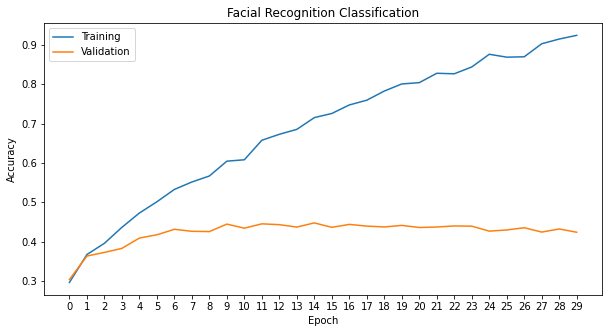

In [6]:
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Facial Recognition Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()

In [18]:
def predict_image(image):
    test_transforms = transforms.Compose([transforms.ToTensor(),])
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [19]:
def get_random_images(num):
    test_transforms = transforms.Compose([transforms.ToTensor(),])
    data = datasets.ImageFolder('images/test', transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

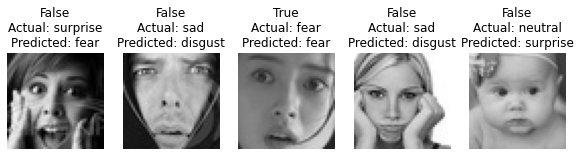

In [24]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(res) + "\nActual: " + classes[int(labels[ii])] + "\nPredicted: "+str(classes[index]))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [36]:
import cv2

def get_landmarks(img_name):
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    #img = cv2.imread(img_name)
    # save face detection algorithm's url in haarcascade_url variable
    haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"

    # save face detection algorithm's name as haarcascade
    haarcascade = "haarcascade_frontalface_alt2.xml"

    # chech if file is in working directory
    if (haarcascade not in os.listdir(os.curdir)):
        # download file from url and save locally as haarcascade_frontalface_alt2.xml, < 1MB
        urlreq.urlretrieve(haarcascade_url, haarcascade)
        print("File downloaded")

    # create an instance of the Face Detection Cascade Classifier
    detector = cv2.CascadeClassifier(haarcascade)

    # Detect faces using the haarcascade classifier on the "grayscale image"
    faces = detector.detectMultiScale(img)

    if len(faces) == 0:
        faces = np.array([[0,0,48,48]])
        
    img = cv2.imread(img_name)
    LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"

    # save facial landmark detection model's name as LBFmodel
    LBFmodel = "lbfmodel.yaml"

    # check if file is in working directory
    if (LBFmodel not in os.listdir(os.curdir)):
        # download picture from url and save locally as lbfmodel.yaml, < 54MB
        urlreq.urlretrieve(LBFmodel_url, LBFmodel)
        print("File downloaded")

    # create an instance of the Facial landmark Detector with the model
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)

    # Detect landmarks on "image_gray"
    _, landmarks = landmark_detector.fit(img, faces)

    for landmark in landmarks:
        for x,y in landmark[0]:
            # display landmarks on "image_cropped"
            # with white colour in BGR and thickness 1
            cv2.circle(img, (int(x), int(y)), 0, (255, 0, 0), 1)
    plt.axis("off")
    #plt.imshow(img)
    print("new_images/"+(img_name).split(".")[0]+".png")
    plt.imsave("new_images/"+(img_name).split(".")[0]+".png", img)

images/train/angry/24084.jpg
new_images/images/train/angry/24084.png
images/train/angry/19463.jpg
new_images/images/train/angry/19463.png
images/train/angry/11759.jpg
new_images/images/train/angry/11759.png
images/train/angry/9041.jpg


KeyboardInterrupt: 

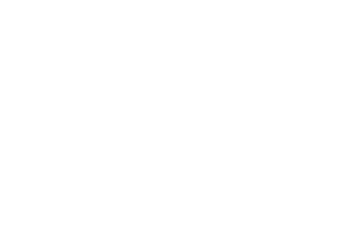

In [30]:
from pathlib import Path


for name in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
    path = "images/train/" + name
    Path("new_images/images/train/"+name).mkdir(parents=True, exist_ok=True)
    files = os.listdir(path)
    for i in range(1, len(files)):
        filename = files[i]
        f = os.path.join(path, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
        get_landmarks(f)

In [ ]:
for name in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
    path = "images/validation/" + name
    Path("new_images/images/validation/"+name).mkdir(parents=True, exist_ok=True)
    files = os.listdir(path)
    for i in range(1, len(files)):
        filename = files[i]
        f = os.path.join(path, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
        get_landmarks(f)

images/test/angry/30797.jpg
new_images/images/test/angry/30797.png
images/test/angry/2100.jpg
new_images/images/test/angry/2100.png
images/test/angry/30783.jpg
new_images/images/test/angry/30783.png
images/test/angry/2672.jpg


KeyboardInterrupt: 

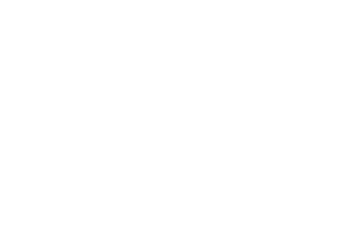

In [ ]:
for name in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
    path = "images/test/" + name
    Path("new_images/images/test/"+name).mkdir(parents=True, exist_ok=True)
    files = os.listdir(path)
    for i in range(1, len(files)):
        filename = files[i]
        f = os.path.join(path, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
        get_landmarks(f)


In [ ]:

data = get_landmarks("21.jpg")